In [1]:
#https://www.kaggle.com/pablocastilla/predict-stock-prices-with-lstm/notebook


#https://www.quandl.com/data/EOD/V-Visa-Inc-V-Stock-Prices-Dividends-and-Splits

#scp -i /c/Users/bmt/.ssh/aws-key.pem /d/2017_working/quick_yahoo_quote_test/quant_data/EOD-V.csv ubuntu@ec2-54-186-239-216.us-west-2.compute.amazonaws.com://home/ubuntu/fastai/data/stock_data/  

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

import os
import sys

In [41]:
LIB_DIR = "/home/ubuntu/fastai/fastai_bmt_reworking/bmt_library"
DATA_DIR = "/home/ubuntu/fastai/data/stock_data/"

In [42]:
os.chdir(LIB_DIR)
print ("current working directory:", os.getcwd())

%matplotlib inline
import yqd #library to access yahoo stock prices
import tools #library with misc tools for deep learning

('current working directory:', '/home/ubuntu/fastai/fastai_bmt_reworking/bmt_library')


In [ ]:
file_name = ""

In [7]:
prices_dataset =  pd.read_csv(DATA_DIR+"EOD-V.csv")
print (prices_dataset.shape)
prices_dataset.head()

(2471, 13)


,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2018-01-09,119.97,119.970,118.66,119.11,6345958,0.0,1,119.97,119.970,118.66,119.11,6345958
1,2018-01-08,118.61,120.477,118.07,119.34,6660722,0.0,1,118.61,120.477,118.07,119.34,6660722
2,2018-01-05,116.99,119.000,116.42,118.86,8590137,0.0,1,116.99,119.000,116.42,118.86,8590137
3,2018-01-04,116.25,117.360,116.03,116.08,7805271,0.0,1,116.25,117.360,116.03,116.08,7805271
4,2018-01-03,114.95,115.785,114.66,115.65,6946106,0.0,1,114.95,115.785,114.66,115.65,6946106


In [8]:
stock_prices = prices_dataset.Close.values.astype('float32')
type(stock_prices), stock_prices.shape[0]

(numpy.ndarray, 2471)

In [9]:
stock_prices = stock_prices.reshape(stock_prices.shape[0], 1)
type(stock_prices), stock_prices.shape

(numpy.ndarray, (2471, 1))

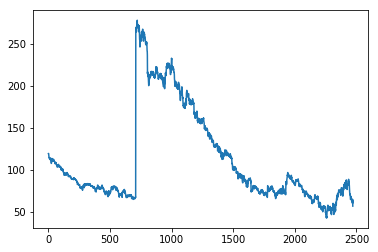

In [10]:
plt.plot(stock_prices)
plt.show()

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

In [12]:
train_size = int(len(stock_prices) * 0.80)
test_size = len(stock_prices) - train_size
print ("train_size:", train_size)
print ("test_size:", test_size)

('train_size:', 1976)
('test_size:', 495)


In [13]:
train = stock_prices[0:train_size,:]
test  = stock_prices[train_size:len(stock_prices),:]
print (len(train))
print (len(test))

1976
495


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		#print ("i:", i, ", a:", a)
		#select left column, row i to row i+look_back
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
		
    #convert to numpy arrays and return
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print ("trainX:", type(trainX), trainX.shape)
print ("trainY:", type(trainY), trainY.shape)
print ("testX:", type(testX), testX.shape)
print ("testY:", type(testY), testY.shape)

('trainX:', <type 'numpy.ndarray'>, (1974, 1))
('trainY:', <type 'numpy.ndarray'>, (1974,))
('testX:', <type 'numpy.ndarray'>, (493, 1))
('testY:', <type 'numpy.ndarray'>, (493,))


In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print ("trainX:", trainX.shape)
print ("testX:", testX.shape)


('trainX:', (1974, 1, 1))
('testX:', (493, 1, 1))


In [17]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM( input_dim=1,
                output_dim=50,
                return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM( 100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

('compilation time : ', 0.009341955184936523)


In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, None, 50)      10400       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, None, 50)      0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 100)           60400       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [19]:
history = model.fit(trainX, trainY, batch_size=128, nb_epoch=10, validation_split=0.05, verbose=1)

Train on 1875 samples, validate on 99 samples
Epoch 1/10
1875/1875 [==============================] - 0s - loss: 0.1198 - val_loss: 0.0013
Epoch 2/10
1875/1875 [==============================] - 0s - loss: 0.0400 - val_loss: 0.0088
Epoch 3/10
1875/1875 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0099
Epoch 4/10
1875/1875 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0042
Epoch 5/10
1875/1875 [==============================] - 0s - loss: 0.0040 - val_loss: 5.7386e-04
Epoch 6/10
1875/1875 [==============================] - 0s - loss: 0.0022 - val_loss: 2.1976e-04
Epoch 7/10
1875/1875 [==============================] - 0s - loss: 0.0022 - val_loss: 1.8829e-04
Epoch 8/10
1875/1875 [==============================] - 0s - loss: 0.0022 - val_loss: 6.7951e-05
Epoch 9/10
1875/1875 [==============================] - 0s - loss: 0.0021 - val_loss: 7.1515e-05
Epoch 10/10
1875/1875 [==============================] - 0s - loss: 0.0019 - val_loss: 9.0756e-05

In [59]:
def plot_history(history):
    #nb: for this model, acc and val_acc do not appear in history. why? model layers dependent?
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    #plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    #plt.title('model accuracy')
    #plt.ylabel('accuracy')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'validate'], loc='upper left')
    #plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'], color='red')
    plt.plot(history.history['val_loss'], color='blue')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()


In [60]:
type(history)
print(history.history.keys())

['loss', 'val_loss']


['loss', 'val_loss']


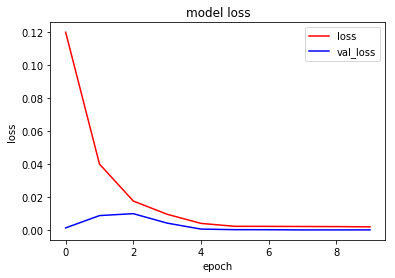

In [61]:
plot_history(history)

In [34]:
def plot_results_multiple(predicted_data, true_data, length):
    
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:], color='red')
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:], color='blue')
    plt.show()

In [21]:
#predict length consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

In [22]:
predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)


[[ 0.19921643]]
[[ 0.41489109]]
[[ 0.84025955]]
[[ 1.76129842]]
[[ 3.60229182]]


In [23]:
#print(MinMaxScaler.inverse_transform(scaler, np.array(predictions).reshape(-1, 1)))
#code above produces same output as below
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
#code above is used in method plot_results_multiple
#MinMaxScaler.inverse_transform


[[  89.40917206]
 [ 140.28036499]
 [ 240.61203003]
 [ 457.85748291]
 [ 892.09259033]]


In [29]:
print ("predictions:", type(predictions), len(predictions), type(predictions[0]))
print ("testY:", type(testY), testY.shape)
print ("predict_length:", type(predict_length), predict_length)

('predictions:', <type 'list'>, 5, <type 'numpy.float32'>)
('testY:', <type 'numpy.ndarray'>, (493,))
('predict_length:', <type 'int'>, 5)


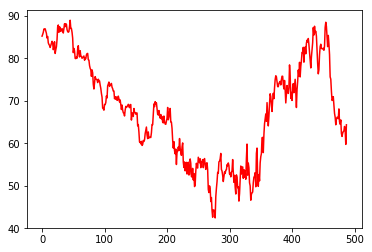

In [37]:
plot_results_multiple(predictions, testY, predict_length)

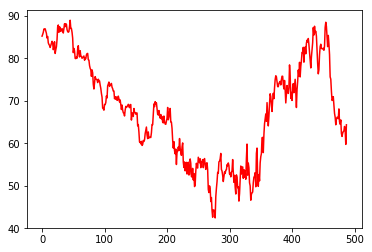

In [36]:
plt.plot(scaler.inverse_transform(testY.reshape(-1, 1))[predict_length:], color='red')
plt.show()

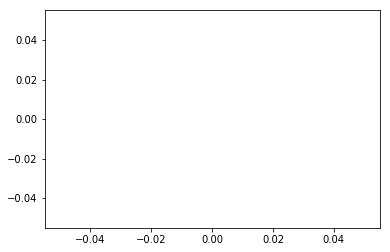

In [38]:
plt.plot(scaler.inverse_transform(np.array(predictions).reshape(-1, 1))[predict_length:], color='blue')
plt.show()